 Load all the required libraries

In [108]:
import numpy as np
from scipy.stats import pearsonr
from statsmodels.tools import add_constant
import statsmodels.api as sm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


In this project, I will analyze Red Wine Data to identify the key variables influencing wine quality. I will start by exploring each variable individually, then examine the correlations between these variables and wine quality. Finally, I will develop a linear model to predict wine quality using a test data set.

Load the data

In [44]:
wine_df = pd.read_excel('wine_file_3.xlsx')
wine_df.columns = wine_df.iloc[0]

# Drop the first row, since it's now the header
wine_df = wine_df[1:].reset_index(drop=True)

wine_df = wine_df.drop(wine_df.columns[0], axis=1)

In [45]:
# Convert all cells in the DataFrame to floats
wine_df = wine_df.astype(float)

In [46]:
wine_df.head(4)

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6.0


In [48]:
# Creating a new Categorical Variable called 'Rating'
wine_df['rating'] = np.where(wine_df['quality'].astype(int) < 5, 'bad', 
                             np.where(wine_df['quality'].astype(int) < 7, 'average', 'good'))
wine_df['rating'] = pd.Categorical(wine_df['rating'], categories=['bad', 'average', 'good'], ordered=True)

**Structure and summary of the DataFrame**

In [49]:
# Display structure and summary of the DataFrame
print(wine_df.info())
print(wine_df.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   fixed.acidity         1599 non-null   float64 
 1   volatile.acidity      1599 non-null   float64 
 2   citric.acid           1599 non-null   float64 
 3   residual.sugar        1599 non-null   float64 
 4   chlorides             1599 non-null   float64 
 5   free.sulfur.dioxide   1599 non-null   float64 
 6   total.sulfur.dioxide  1599 non-null   float64 
 7   density               1599 non-null   float64 
 8   pH                    1599 non-null   float64 
 9   sulphates             1599 non-null   float64 
 10  alcohol               1599 non-null   float64 
 11  quality               1599 non-null   float64 
 12  rating                1599 non-null   category
dtypes: category(1), float64(12)
memory usage: 151.7 KB
None
0       fixed.acidity  volatile.acidity  citric.acid

**Univariate Plots**

Before analyzing the relationships between variables, I will first plot the distribution of each variable to understand their characteristics, such as whether they follow a normal distribution, or are positively or negatively skewed. This will provide insight into what to expect when comparing variables. Additionally, I will remove extreme outliers from the dataset to ensure a more robust analysis.

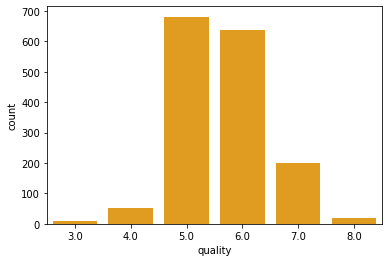

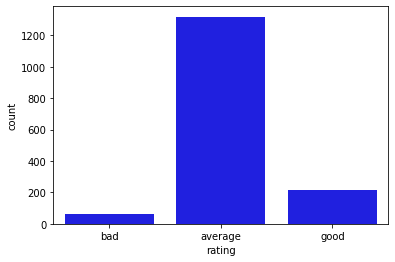

In [50]:
# Plot the distribution of 'quality'
sns.countplot(x='quality', data=wine_df, color='orange')
plt.show()

# Plot the distribution of 'rating'
sns.countplot(x='rating', data=wine_df, color='blue')
plt.show()

From the initial plots, it appears that most wines in the dataset are of average quality, with high and low-quality wines being rare, almost like outliers. This raises questions about the accuracy and completeness of the data, as well as the geographical scope of the data collection. If the data is concentrated in a specific location, it could impact the ability to accurately model wine quality, given the limited representation of both high and low-quality wines. Further analysis of additional plots is needed to explore these concerns.

In [51]:
wine_df.iloc[:,:-1].sample(3)

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
644,9.9,0.54,0.45,2.3,0.071,16.0,40.0,0.9991,3.39,0.62,9.4,5.0
36,7.8,0.60,0.14,2.4,0.086,3.0,15.0,0.9975,3.42,0.60,10.8,6.0
443,10.0,0.44,0.49,2.7,0.077,11.0,19.0,0.9963,3.23,0.63,11.6,7.0


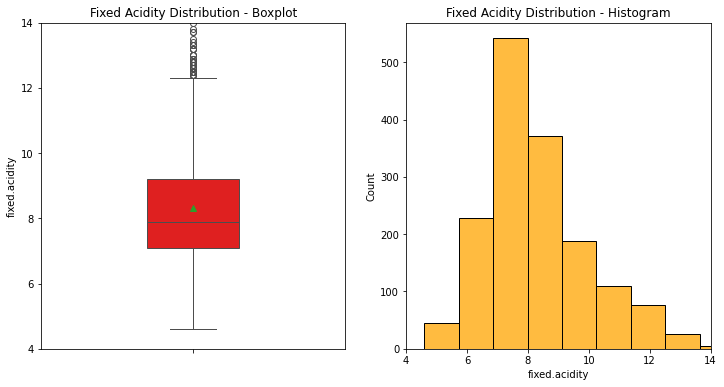

In [101]:
# Plot Fixed Acidity
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y=wine_df['fixed.acidity'], color='red', width=0.3, showmeans=True)
plt.ylim(4, 14)
plt.title('Fixed Acidity Distribution - Boxplot')
plt.subplot(1, 2, 2)
sns.histplot(wine_df['fixed.acidity'], bins=10, color='orange')
plt.xlim(4, 14)
plt.title('Fixed Acidity Distribution - Histogram')
plt.show()

The distribution of Fixed Acidity is positively skewed. The median is around 8 with high concentration of wines with Fixed Acidity but due to some outliers, the mean has been a bit more.

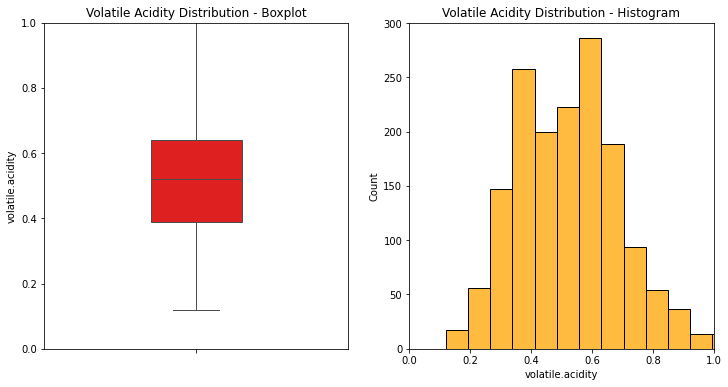

In [57]:
# Plot Volatile Acidity
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y=wine_df['volatile.acidity'], color='red', width=0.3)
plt.ylim(0, 1)
plt.title('Volatile Acidity Distribution - Boxplot')
plt.subplot(1, 2, 2)
sns.histplot(wine_df['volatile.acidity'], bins=20, color='orange')
plt.xlim(0, 1)
plt.title('Volatile Acidity Distribution - Histogram')
plt.show()

The distribution of Volatile acidity looks like Bimodal with two peaks around 0.4 and 0.6.

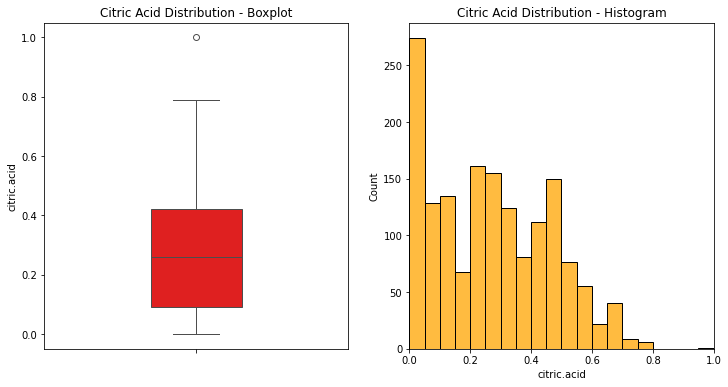

In [99]:
# Plot Citric Acid
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y=wine_df['citric.acid'], color='red', width=0.3)
plt.title('Citric Acid Distribution - Boxplot')
plt.subplot(1, 2, 2)
sns.histplot(wine_df['citric.acid'], bins=20, color='orange')
plt.xlim(0, 1)
plt.title('Citric Acid Distribution - Histogram')
plt.show()

Above plot looks like an exponential distribution

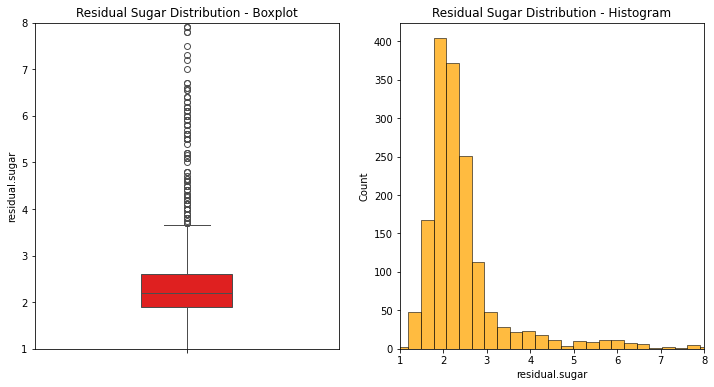

In [59]:
# Plot Residual Sugar
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y=wine_df['residual.sugar'], color='red', width=0.3)
plt.ylim(1, 8)
plt.title('Residual Sugar Distribution - Boxplot')
plt.subplot(1, 2, 2)
sns.histplot(wine_df['residual.sugar'], bins=50, color='orange')
plt.xlim(1, 8)
plt.title('Residual Sugar Distribution - Histogram')
plt.show()

The distribution of Residual Sugar is again positively skewed with high peaks at around 2.3 with many outliers present at the higher ranges.

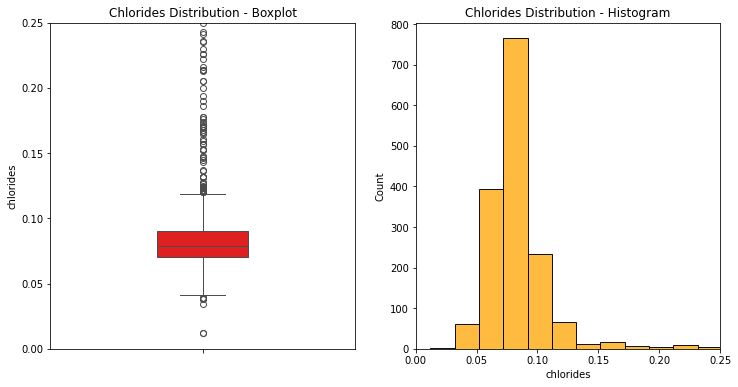

In [60]:
# Plot Chlorides
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y=wine_df['chlorides'], color='red', width=0.3)
plt.ylim(0, 0.25)
plt.title('Chlorides Distribution - Boxplot')
plt.subplot(1, 2, 2)
sns.histplot(wine_df['chlorides'], bins=30, color='orange')
plt.xlim(0, 0.25)
plt.title('Chlorides Distribution - Histogram')
plt.show()


For Chlorides also, we see a similar distribution like Residual Sugar. 

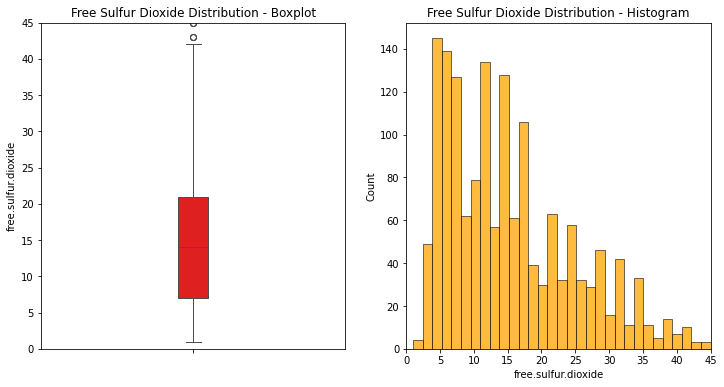

In [98]:
# Plot Free Sulfur Dioxide
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y=wine_df['free.sulfur.dioxide'], color='red', width=0.1)
plt.ylim(0, 45)
plt.title('Free Sulfur Dioxide Distribution - Boxplot')
plt.subplot(1, 2, 2)
sns.histplot(wine_df['free.sulfur.dioxide'], bins=50, color='orange')
plt.xlim(0, 45)
plt.title('Free Sulfur Dioxide Distribution - Histogram')
plt.show()


For Free Sulphur Dioxide, there is a high peak at 5 but then it again follows the same positively skewed long tailed patterns with some outliers in the high range

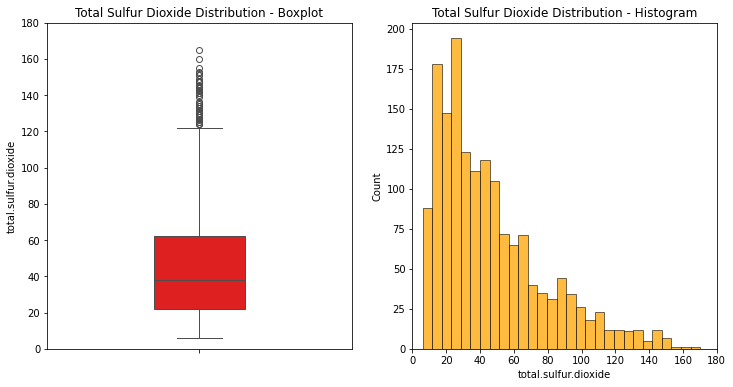

In [100]:
# Plot total Sulfur Dioxide
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y=wine_df['total.sulfur.dioxide'], color='red', width=0.3)
plt.ylim(0, 180)
plt.title('Total Sulfur Dioxide Distribution - Boxplot')
plt.subplot(1, 2, 2)
sns.histplot(wine_df['total.sulfur.dioxide'], bins=50, color='orange')
plt.xlim(0, 180)
plt.title('Total Sulfur Dioxide Distribution - Histogram')
plt.show()

Being a superset of the previous variable, Total Sulphur Dioxide also follows a similar pattern.



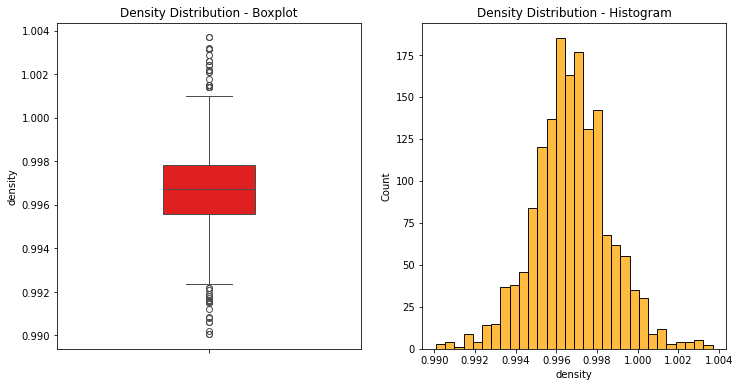

In [63]:
# Plot Density
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y=wine_df['density'], color='red', width=0.3)
plt.title('Density Distribution - Boxplot')
plt.subplot(1, 2, 2)
sns.histplot(wine_df['density'], bins=30, color='orange')
plt.title('Density Distribution - Histogram')
plt.show()

For the Density variable, we see something new for the first time. This Variable has almost a perfect Normal Distribution.

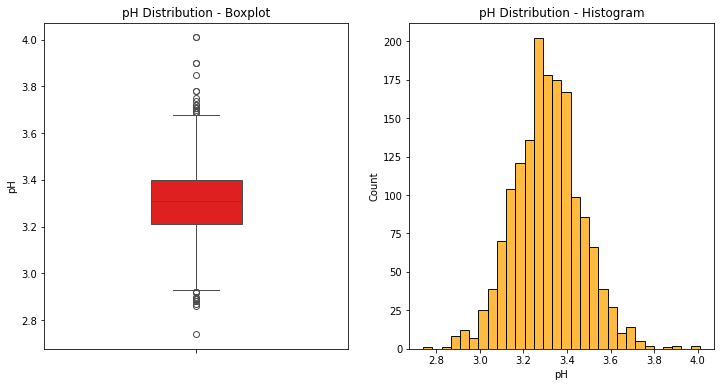

In [64]:
# Plot pH
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y=wine_df['pH'], color='red', width=0.3)
plt.title('pH Distribution - Boxplot')
plt.subplot(1, 2, 2)
sns.histplot(wine_df['pH'], bins=30, color='orange')
plt.title('pH Distribution - Histogram')
plt.show()

pH also has a very Normally distributed shape.

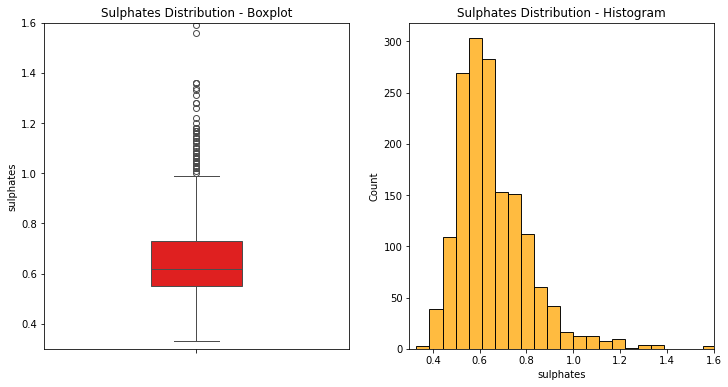

In [65]:
# Plot Sulphates
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y=wine_df['sulphates'], color='red', width=0.3)
plt.ylim(0.3, 1.6)
plt.title('Sulphates Distribution - Boxplot')
plt.subplot(1, 2, 2)
sns.histplot(wine_df['sulphates'], bins=30, color='orange')
plt.xlim(0.3, 1.6)
plt.title('Sulphates Distribution - Histogram')
plt.show()

Sulphates also exhibit a similar long tailed distribution like Chlorides or Free/Total Sulphur Dioxide. It has relatively less outliers.

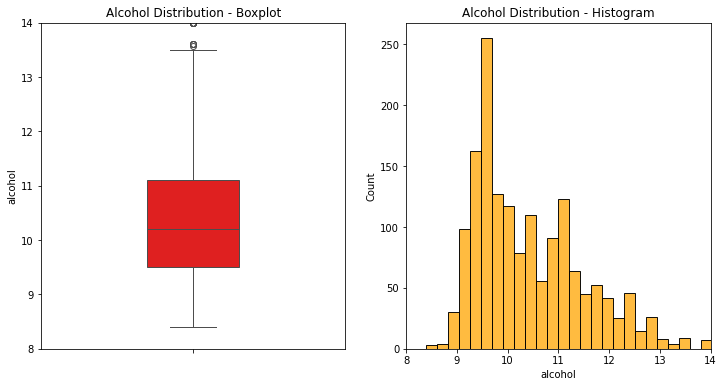

In [66]:
# Plot Alcohol
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y=wine_df['alcohol'], color='red', width=0.3)
plt.ylim(8, 14)
plt.title('Alcohol Distribution - Boxplot')
plt.subplot(1, 2, 2)
sns.histplot(wine_df['alcohol'], bins=30, color='orange')
plt.xlim(8, 14)
plt.title('Alcohol Distribution - Histogram')
plt.show()

Alcohol also follows a skewed distribution but here the skewness is less than that of Chlorides or Residual Sugars.

Analysis of Univariate analysis:

The main focus of this analysis is to understand which factors influence the quality of wine. Initially, I hypothesize that acidity levels (fixed, volatile, or citric) and pH might play significant roles in determining wine quality. I also suspect that residual sugar could impact the sweetness and, consequently, the taste and quality of the wine. 

Upon examining the dataset, citric acid stands out due to its unusual distribution, which is almost rectangular, unlike other variables. This raises concerns about the completeness of the data. Additionally, the distribution of various variables reveals potential issues with outliers: density and pH appear mostly normal with a few outliers, while residual sugar and chloride show extreme outliers. Fixed and volatile acidity, sulfur dioxide levels, alcohol, and sulphates exhibit long tails due to outliers. The large number of zero values for citric acid could suggest incomplete data entry.

**Bivariate Plots**

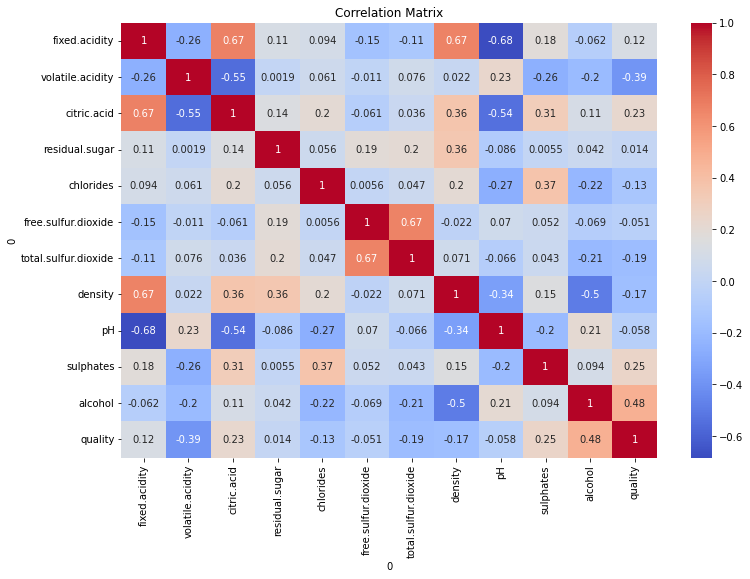

In [52]:
# Correlation matrix
correlation_matrix = wine_df.iloc[:,:-1].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [68]:
# Filter strong correlations (absolute correlation > 0.3, and not the diagonal of 1)
strong_correlations = correlation_matrix[(abs(correlation_matrix) > 0.3) & (correlation_matrix != 1)]
print(strong_correlations)

0                     fixed.acidity  volatile.acidity  citric.acid  \
0                                                                    
fixed.acidity                   NaN               NaN     0.671703   
volatile.acidity                NaN               NaN    -0.552496   
citric.acid                0.671703         -0.552496          NaN   
residual.sugar                  NaN               NaN          NaN   
chlorides                       NaN               NaN          NaN   
free.sulfur.dioxide             NaN               NaN          NaN   
total.sulfur.dioxide            NaN               NaN          NaN   
density                    0.668047               NaN     0.364947   
pH                        -0.682978               NaN    -0.541904   
sulphates                       NaN               NaN     0.312770   
alcohol                         NaN               NaN          NaN   
quality                         NaN         -0.390558          NaN   

0                  

In reviewing the data, several points stand out:

1. Volatile acidity surprisingly shows a positive correlation with pH, which contradicts the usual expectation that acidity increases as pH decreases. This unusual result may suggest the presence of Simpson's Paradox, warranting further investigation.
2. There is a strong correlation between density and fixed acidity.
3. The variables most strongly correlated with wine quality are volatile acidity and alcohol content.
4. Alcohol has a negative correlation with density, consistent with the fact that alcohol is less dense than water.

Next, I will create box plots to explore these relationships further and ensure nothing was overlooked in the correlation analysis.

**Boxplots for wine quality**

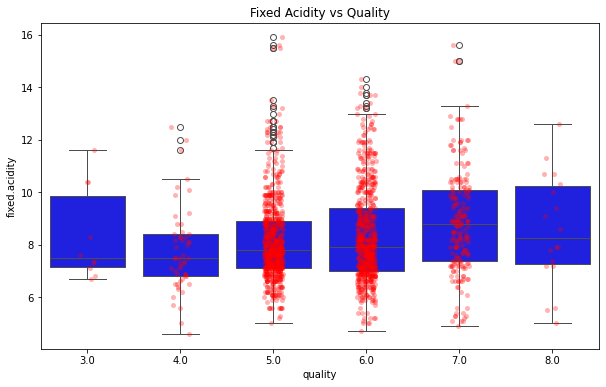

In [69]:
# Fixed Acidity vs Quality
plt.figure(figsize=(10, 6))
sns.boxplot(x='quality', y='fixed.acidity', data=wine_df, color='blue')
sns.stripplot(x='quality', y='fixed.acidity', data=wine_df, color='red', jitter=True, alpha=0.3)
plt.title('Fixed Acidity vs Quality')
plt.show()

Fixed Acidity seems to have little to no effect on Quality. The mean and median values of fixed acidity remain almost unchanged with an increase in quality.

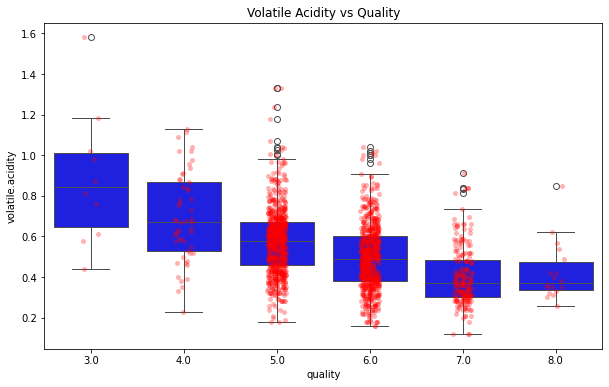

In [70]:
# Volatile Acidity vs Quality
plt.figure(figsize=(10, 6))
sns.boxplot(x='quality', y='volatile.acidity', data=wine_df, color='blue')
sns.stripplot(x='quality', y='volatile.acidity', data=wine_df, color='red', jitter=True, alpha=0.3)
plt.title('Volatile Acidity vs Quality')
plt.show()

Volatile acidity appears to have a negative impact on the quality of wine. As volatile acidity increases, the quality of the wine decreases.

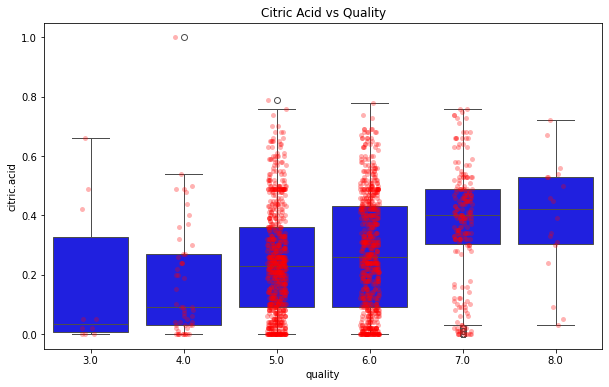

In [71]:
# Citric Acid vs Quality
plt.figure(figsize=(10, 6))
sns.boxplot(x='quality', y='citric.acid', data=wine_df, color='blue')
sns.stripplot(x='quality', y='citric.acid', data=wine_df, color='red', jitter=True, alpha=0.3)
plt.title('Citric Acid vs Quality')
plt.show()

Citric acid seems to have a positive correlation with wine quality. Better wines have higher Citric Acid content.

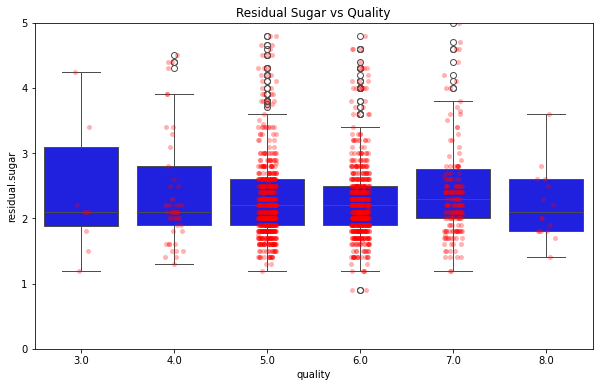

In [72]:
# Residual Sugar vs Quality
plt.figure(figsize=(10, 6))
sns.boxplot(x='quality', y='residual.sugar', data=wine_df, color='blue')
sns.stripplot(x='quality', y='residual.sugar', data=wine_df, color='red', jitter=True, alpha=0.3)
plt.ylim(0, 5)
plt.title('Residual Sugar vs Quality')
plt.show()

Residual sugar does not seem to have a significant effect on wine quality. The mean values for residual sugar are almost the same across all wine quality level

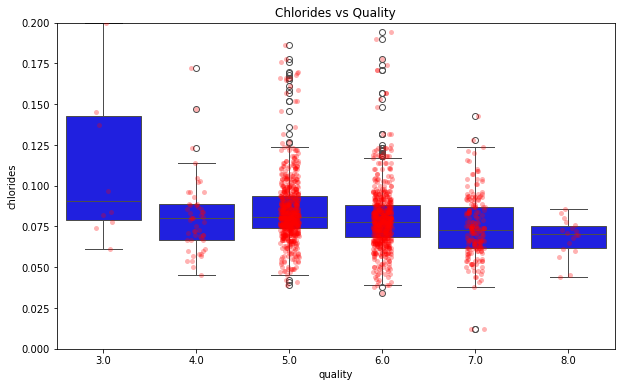

In [73]:
# Chlorides vs Quality
plt.figure(figsize=(10, 6))
sns.boxplot(x='quality', y='chlorides', data=wine_df, color='blue')
sns.stripplot(x='quality', y='chlorides', data=wine_df, color='red', jitter=True, alpha=0.3)
plt.ylim(0, 0.2)
plt.title('Chlorides vs Quality')
plt.show()

Lower chloride concentrations seem to be associated with better wine quality, although the correlation is weak.

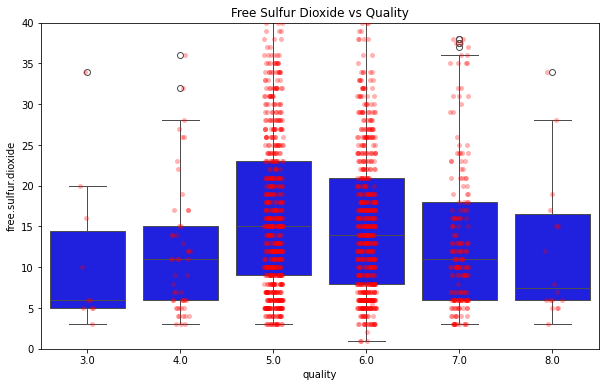

In [74]:
# Free Sulfur Dioxide vs Quality
plt.figure(figsize=(10, 6))
sns.boxplot(x='quality', y='free.sulfur.dioxide', data=wine_df, color='blue')
sns.stripplot(x='quality', y='free.sulfur.dioxide', data=wine_df, color='red', jitter=True, alpha=0.3)
plt.ylim(0, 40)
plt.title('Free Sulfur Dioxide vs Quality')
plt.show()

Low concentrations of free sulfur dioxide seem to produce poor-quality wine, while high concentrations lead to average-quality wine.

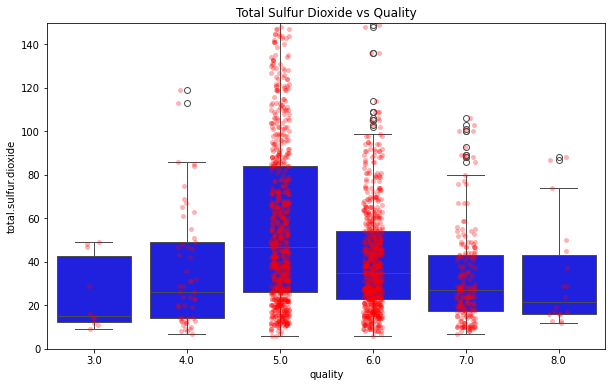

In [75]:
# Total Sulfur Dioxide vs Quality
plt.figure(figsize=(10, 6))
sns.boxplot(x='quality', y='total.sulfur.dioxide', data=wine_df, color='blue')
sns.stripplot(x='quality', y='total.sulfur.dioxide', data=wine_df, color='red', jitter=True, alpha=0.3)
plt.ylim(0, 150)
plt.title('Total Sulfur Dioxide vs Quality')
plt.show()

Total sulfur dioxide follows a similar pattern to free sulfur dioxide.

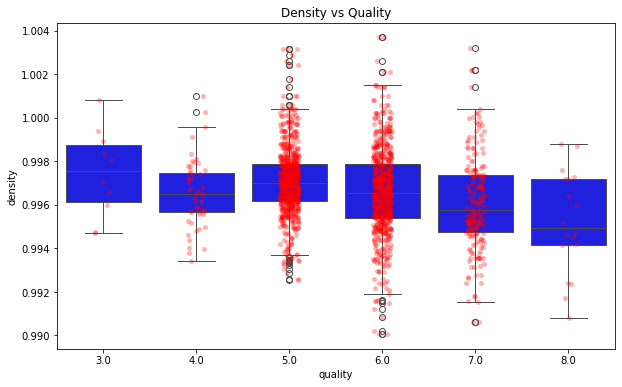

In [76]:
# Density vs Quality
plt.figure(figsize=(10, 6))
sns.boxplot(x='quality', y='density', data=wine_df, color='blue')
sns.stripplot(x='quality', y='density', data=wine_df, color='red', jitter=True, alpha=0.3)
plt.title('Density vs Quality')
plt.show()

Better wines seem to have lower densities. However, the low density may be due to higher alcohol content, which could be the actual driving factor for better wine.

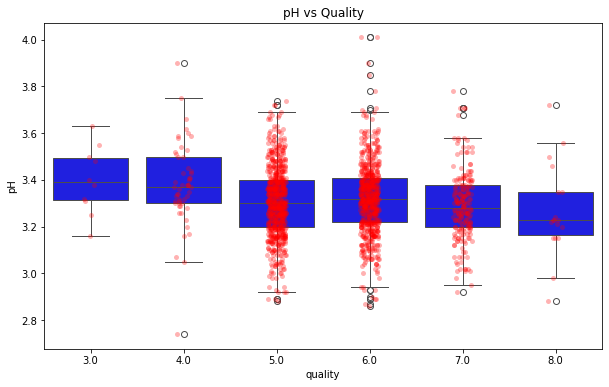

In [77]:
# pH vs Quality
plt.figure(figsize=(10, 6))
sns.boxplot(x='quality', y='pH', data=wine_df, color='blue')
sns.stripplot(x='quality', y='pH', data=wine_df, color='red', jitter=True, alpha=0.3)
plt.title('pH vs Quality')
plt.show()

Better wines tend to have lower pH, indicating higher acidity. However, there are a few outliers.

<Figure size 720x432 with 0 Axes>

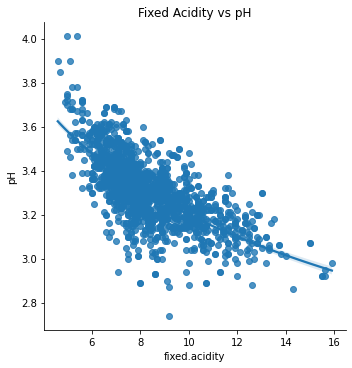

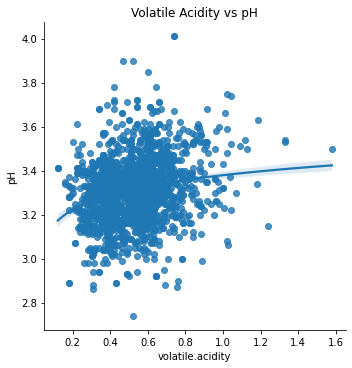

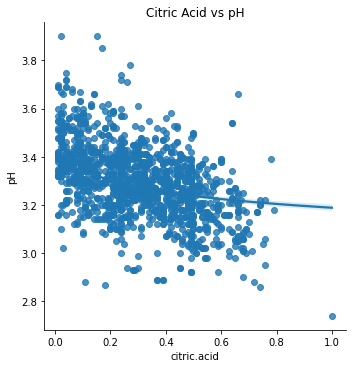

In [105]:
# Plot relationships between acidity and pH
plt.figure(figsize=(10, 6))
sns.lmplot(x='fixed.acidity', y='pH', data=wine_df, logx=True)
plt.title('Fixed Acidity vs pH')
plt.show()

sns.lmplot(x='volatile.acidity', y='pH', data=wine_df, logx=True)
plt.title('Volatile Acidity vs pH')
plt.show()

sns.lmplot(x='citric.acid', y='pH', data=wine_df[wine_df['citric.acid'] > 0], logx=True)
plt.title('Citric Acid vs pH')
plt.show()

These three plots make us revisit our earlier question. We observed a positive correlation between volatile acidity and pH, but acidity should negatively correlate with pH. Could this be a case of Simpson’s Paradox? Let’s investigate.

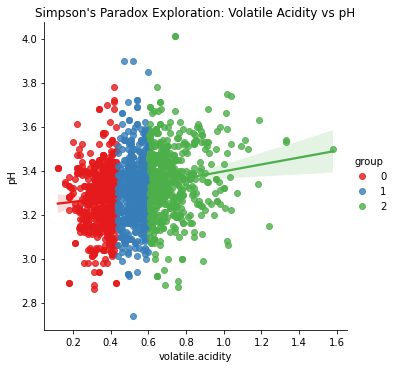

In [79]:
# Simpson's Paradox (note: this will need specific logic as there is no direct function for it)
# Below is a simplified approach assuming segmentation based on certain conditions
wine_df['group'] = pd.qcut(wine_df['volatile.acidity'], 3, labels=False)
sns.lmplot(x='volatile.acidity', y='pH', data=wine_df, hue='group', palette='Set1')
plt.title('Simpson\'s Paradox Exploration: Volatile Acidity vs pH')
plt.show()

This plot explores the potential presence of Simpson's Paradox in the relationship between volatile acidity and pH in the wine dataset. By segmenting the data into three groups based on levels of volatile acidity, the plot displays separate regression lines for each group, highlighting how the relationship between volatile acidity and pH may differ across these segments. If the slopes of these lines vary significantly, it suggests that the relationship observed within each group may differ from the overall trend, indicating Simpson's Paradox. This analysis helps reveal hidden patterns that could be obscured when looking at the aggregated data alone.

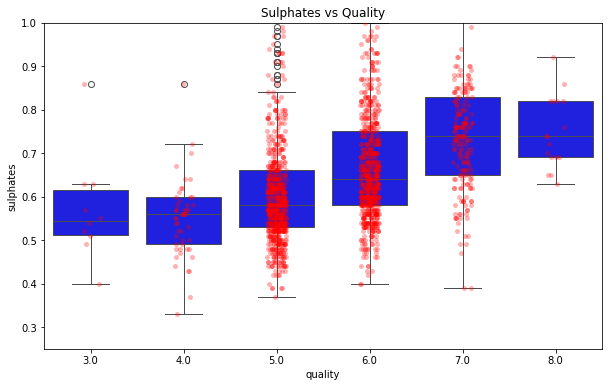

In [81]:
# Sulphates vs Quality
plt.figure(figsize=(10, 6))
sns.boxplot(x='quality', y='sulphates', data=wine_df, color='blue')
sns.stripplot(x='quality', y='sulphates', data=wine_df, color='red', jitter=True, alpha=0.3)
plt.ylim(0.25, 1)
plt.title('Sulphates vs Quality')
plt.show()

Higher concentrations of sulphates seem to be associated with better wine quality, despite many outliers.

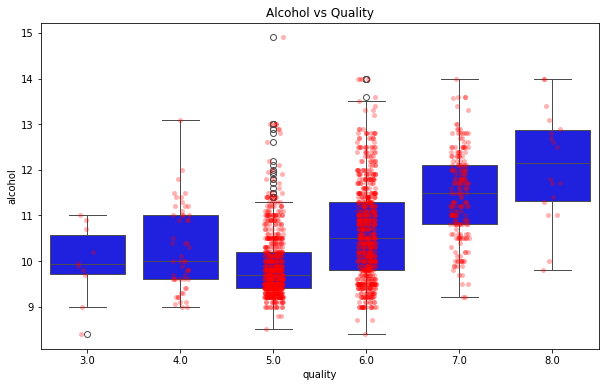

In [82]:
# Alcohol vs Quality
plt.figure(figsize=(10, 6))
sns.boxplot(x='quality', y='alcohol', data=wine_df, color='blue')
sns.stripplot(x='quality', y='alcohol', data=wine_df, color='red', jitter=True, alpha=0.3)
plt.title('Alcohol vs Quality')
plt.show()

Higher alcohol content appears to be a strong indicator of better wine quality, although there are many outliers.

**Linear Model Analysis**

In [84]:
# Prepare the data for the linear model
X = wine_df[['alcohol']]
y = wine_df['quality']

# Add a constant term to the predictor
X = sm.add_constant(X)

# Fit the linear model
model = sm.OLS(y, X).fit()

# Print the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     468.3
Date:                Fri, 23 Aug 2024   Prob (F-statistic):           2.83e-91
Time:                        17:45:56   Log-Likelihood:                -1721.1
No. Observations:                1599   AIC:                             3446.
Df Residuals:                    1597   BIC:                             3457.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8750      0.175     10.732      0.0

Based on the R-squared value, we see that Alcohol alone contributes to only about 22% of the Wine quality. So there must be other variables at play here. Next, we will perform a correlation test against each variable to determine their relationship to the wine quality.

In [85]:


# Function to calculate the Pearson correlation coefficient
def simple_cor_test(x, y):
    return pearsonr(x, y)[0]

# Correlations between wine quality and other variables
correlations = {
    'fixed.acidity': simple_cor_test(wine_df['fixed.acidity'], wine_df['quality']),
    'volatile.acidity': simple_cor_test(wine_df['volatile.acidity'], wine_df['quality']),
    'citric.acid': simple_cor_test(wine_df['citric.acid'], wine_df['quality']),
    'log10.residual.sugar': simple_cor_test(np.log10(wine_df['residual.sugar']), wine_df['quality']),
    'log10.chlorides': simple_cor_test(np.log10(wine_df['chlorides']), wine_df['quality']),
    'free.sulfur.dioxide': simple_cor_test(wine_df['free.sulfur.dioxide'], wine_df['quality']),
    'total.sulfur.dioxide': simple_cor_test(wine_df['total.sulfur.dioxide'], wine_df['quality']),
    'density': simple_cor_test(wine_df['density'], wine_df['quality']),
    'pH': simple_cor_test(wine_df['pH'], wine_df['quality']),
    'log10.sulphates': simple_cor_test(np.log10(wine_df['sulphates']), wine_df['quality']),
    'alcohol': simple_cor_test(wine_df['alcohol'], wine_df['quality'])
}

# Print the correlations
print(correlations)

{'fixed.acidity': 0.12405164911322426, 'volatile.acidity': -0.3905577802640073, 'citric.acid': 0.2263725143180414, 'log10.residual.sugar': 0.023533306758790392, 'log10.chlorides': -0.17613996496029874, 'free.sulfur.dioxide': -0.0506560572442764, 'total.sulfur.dioxide': -0.1851002889265378, 'density': -0.17491922778334873, 'pH': -0.05773139120538212, 'log10.sulphates': 0.3086419323210112, 'alcohol': 0.47616632400113607}


From the correlation test, it seems that the following variables have a higher correlation to Wine Quality.---

Alcohol,
Sulphates(log10),
Volatile Acidity,
Citric Acid.

*Observations*

	1.	Fixed Acidity seems to have almost no effect on quality.
	2.	Volatile Acidity seems to have a negative correlation with quality.
	3.	Better wines seem to have higher concentrations of Citric Acid.
	4.	Better wines seem to have higher alcohol percentages. However, a linear model around alcohol shows that it only explains about 22% of the variance in wine quality, so other factors must be at play.
	5.	Lower chloride concentrations seem to produce better quality wines, although the correlation is weak.
	6.	Better wines seem to have lower densities, possibly due to higher alcohol content.
	7.	Better wines seem to be more acidic.
	8.	Residual sugar almost has no effect on wine quality.


**Multivariate plots**

<Figure size 720x432 with 0 Axes>

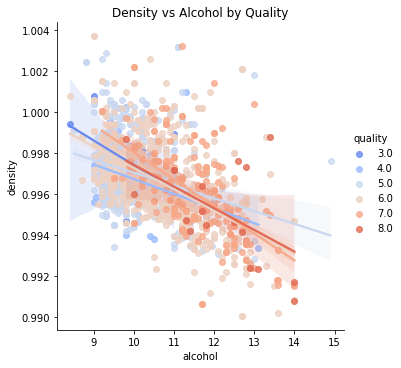

<Figure size 720x432 with 0 Axes>

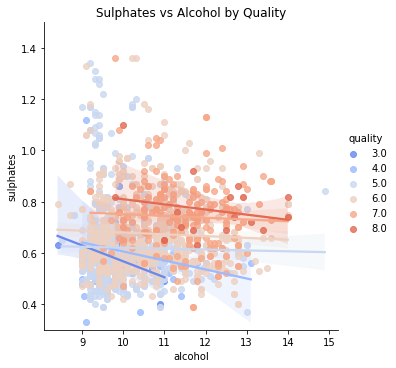

<Figure size 720x432 with 0 Axes>

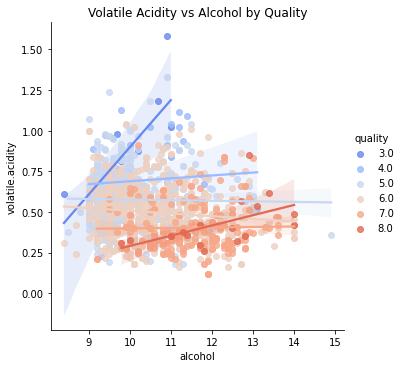

<Figure size 720x432 with 0 Axes>

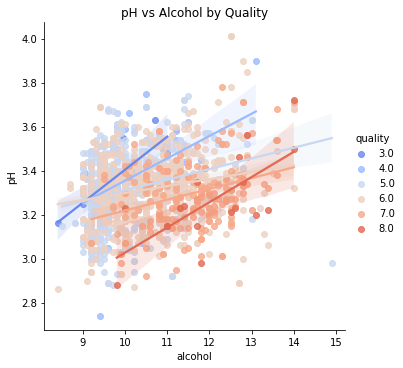

<Figure size 720x432 with 0 Axes>

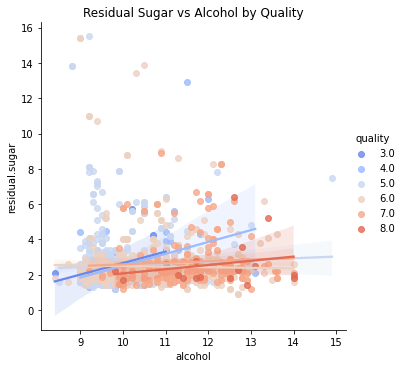

<Figure size 720x432 with 0 Axes>

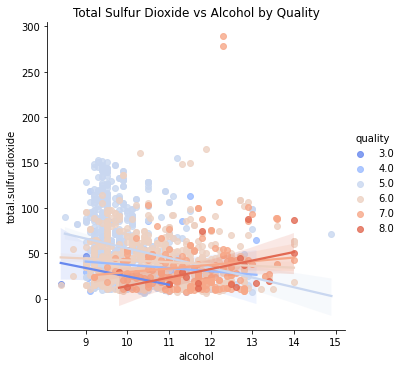

In [86]:


# Density vs Alcohol vs Quality
plt.figure(figsize=(10, 6))
sns.lmplot(x='alcohol', y='density', hue='quality', data=wine_df, palette='coolwarm', fit_reg=True)
plt.title('Density vs Alcohol by Quality')
plt.show()

# Sulphates vs Alcohol vs Quality
plt.figure(figsize=(10, 6))
sns.lmplot(x='alcohol', y='sulphates', hue='quality', data=wine_df, palette='coolwarm', fit_reg=True)
plt.ylim(0.3, 1.5)
plt.title('Sulphates vs Alcohol by Quality')
plt.show()

# Volatile Acidity vs Alcohol vs Quality
plt.figure(figsize=(10, 6))
sns.lmplot(x='alcohol', y='volatile.acidity', hue='quality', data=wine_df, palette='coolwarm', fit_reg=True)
plt.title('Volatile Acidity vs Alcohol by Quality')
plt.show()

# pH vs Alcohol vs Quality
plt.figure(figsize=(10, 6))
sns.lmplot(x='alcohol', y='pH', hue='quality', data=wine_df, palette='coolwarm', fit_reg=True)
plt.title('pH vs Alcohol by Quality')
plt.show()

# Residual Sugar vs Alcohol vs Quality
plt.figure(figsize=(10, 6))
sns.lmplot(x='alcohol', y='residual.sugar', hue='quality', data=wine_df, palette='coolwarm', fit_reg=True)
plt.title('Residual Sugar vs Alcohol by Quality')
plt.show()

# Total Sulfur Dioxide vs Alcohol vs Quality
plt.figure(figsize=(10, 6))
sns.lmplot(x='alcohol', y='total.sulfur.dioxide', hue='quality', data=wine_df, palette='coolwarm', fit_reg=True)
plt.title('Total Sulfur Dioxide vs Alcohol by Quality')
plt.show()

Effect of Acids on Wine Quality

<Figure size 720x432 with 0 Axes>

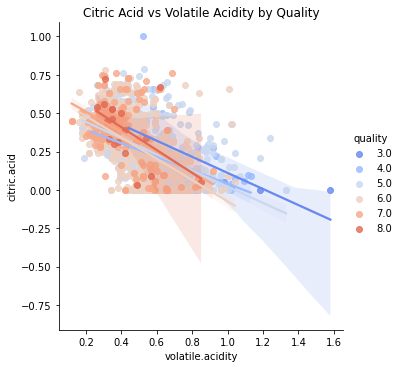

<Figure size 720x432 with 0 Axes>

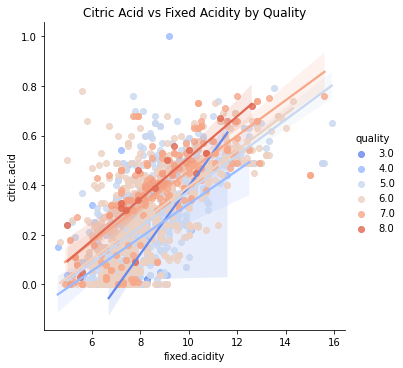

<Figure size 720x432 with 0 Axes>

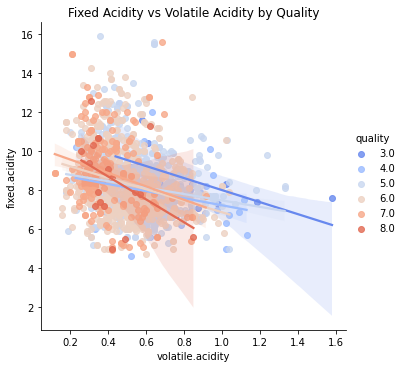

In [87]:
# Citric Acid vs Volatile Acidity vs Quality
plt.figure(figsize=(10, 6))
sns.lmplot(x='volatile.acidity', y='citric.acid', hue='quality', data=wine_df, palette='coolwarm', fit_reg=True)
plt.title('Citric Acid vs Volatile Acidity by Quality')
plt.show()

# Citric Acid vs Fixed Acidity vs Quality
plt.figure(figsize=(10, 6))
sns.lmplot(x='fixed.acidity', y='citric.acid', hue='quality', data=wine_df, palette='coolwarm', fit_reg=True)
plt.title('Citric Acid vs Fixed Acidity by Quality')
plt.show()

# Fixed Acidity vs Volatile Acidity vs Quality
plt.figure(figsize=(10, 6))
sns.lmplot(x='volatile.acidity', y='fixed.acidity', hue='quality', data=wine_df, palette='coolwarm', fit_reg=True)
plt.title('Fixed Acidity vs Volatile Acidity by Quality')
plt.show()

**Linear Modelling**

In [88]:


# Split the data into training and testing sets
train_df, test_df = train_test_split(wine_df, test_size=0.4, random_state=1221)

# Build a series of linear models with increasing complexity
X_train = add_constant(train_df[['alcohol']])
m1 = sm.OLS(train_df['quality'], X_train).fit()

X_train = add_constant(train_df[['alcohol', 'sulphates']])
m2 = sm.OLS(train_df['quality'], X_train).fit()

X_train = add_constant(train_df[['alcohol', 'sulphates', 'volatile.acidity']])
m3 = sm.OLS(train_df['quality'], X_train).fit()

X_train = add_constant(train_df[['alcohol', 'sulphates', 'volatile.acidity', 'citric.acid']])
m4 = sm.OLS(train_df['quality'], X_train).fit()

X_train = add_constant(train_df[['alcohol', 'sulphates', 'volatile.acidity', 'citric.acid', 'fixed.acidity']])
m5 = sm.OLS(train_df['quality'], X_train).fit()

X_train = add_constant(train_df[['alcohol', 'sulphates', 'volatile.acidity', 'citric.acid', 'fixed.acidity', 'pH']])
m6 = sm.OLS(train_df['quality'], X_train).fit()

# Compare models
print(sm.stats.anova_lm(m1, m2, m3, m4, m5, m6))

   df_resid         ssr  df_diff    ss_diff          F        Pr(>F)
0     957.0  485.418528      0.0        NaN        NaN           NaN
1     956.0  453.979201      1.0  31.439327  72.332504  6.937909e-17
2     955.0  421.725473      1.0  32.253729  74.206200  2.876845e-17
3     954.0  421.702453      1.0   0.023019   0.052961  8.180384e-01
4     953.0  415.552525      1.0   6.149928  14.149148  1.791741e-04
5     952.0  413.786853      1.0   1.765672   4.062283  4.413177e-02


/Users/mimuw2022/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/anova.py:374: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  table[pr_test][table['F'].isnull()] = np.nan


Overall Interpretation:

	•	The first two variables added to the model (from rows 2 and 3) significantly improve the model fit.
	•	The third variable (row 4) does not significantly improve the model, suggesting it might be unnecessary.
	•	The fourth variable (row 5) adds significant value to the model, while the fifth variable (row 6) provides a marginal improvement.


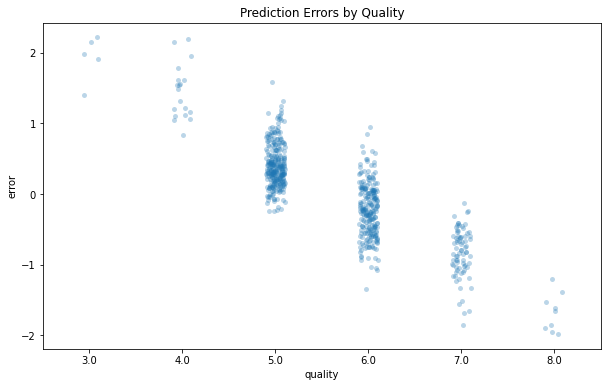

Percentage of variation explained by the model: 36.58%


In [109]:
# Predict on the test set using the best model (m5)
X_test = add_constant(test_df[['alcohol', 'sulphates', 'volatile.acidity', 'citric.acid', 'fixed.acidity']])
predictions = m5.predict(X_test)

# Calculate prediction errors
errors = predictions - test_df['quality']

# Plot prediction errors
wine_predict = pd.DataFrame({
    'quality': test_df['quality'],
    'error': errors
})

plt.figure(figsize=(10, 6))
sns.stripplot(x='quality', y='error', data=wine_predict, jitter=True, alpha=0.3)
plt.title('Prediction Errors by Quality')
plt.show()

# Calculate and print the percentage of variation explained by the model (R^2)
r2 = r2_score(test_df['quality'], predictions)
print(f"Percentage of variation explained by the model: {r2 * 100:.2f}%")

Analysis of the Multivariate Plots
Observations

High Alcohol and Sulaphate content seems to produce better wines.
Citric Acid, even though weakly correlated plays a part in improving the wine quality.

Linear Models Created

I created a couple of linear models. But the main problem was that there was not enough statistical power to have a significant confidence level in the equations produced. Due to the low R-squared value, I saw that alcohol contributes only 22% to the wine quality, and most of the factors converged on the average quality wines. This can be attributed to the fact that our dataset primarily comprised ‘Average’ quality wines, with very few data points for ‘Good’ and ‘Bad’ quality wines in the training dataset. This lack of data made it difficult to predict statistics for the edge cases. A more complete dataset might have helped in better predicting higher range values.

Final Plots and Summary

I saw that alcohol and sulphates played a major role in determining wine quality. In the final linear model I created, I also plotted the error value against the quality, showing the variation in the error percentage across different wine qualities. These three plots are critical for this project, so I included them in the Final Plots and Summary section.


/var/folders/y7/prh1dml914g427qq54908kxw0000gn/T/ipykernel_61916/4093611520.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='quality', y='alcohol', data=wine_df, palette="Blues")


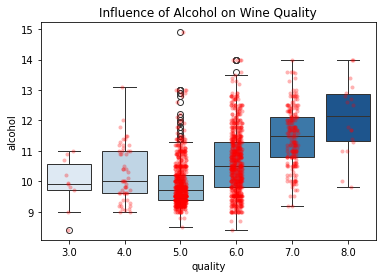

In [91]:

sns.boxplot(x='quality', y='alcohol', data=wine_df, palette="Blues")
sns.stripplot(x='quality', y='alcohol', data=wine_df, color='red', size=4, jitter=True, alpha=0.3)
plt.title("Influence of Alcohol on Wine Quality")
plt.show()

This plot indicates that alcohol percentage plays a significant role in determining wine quality. Higher alcohol percentages are associated with better wine quality. Despite most of the data pertaining to average quality wine, the plot shows that the mean and median coincide for all boxes, implying that the data is normally distributed for each quality category. The high median value in the best quality wines implies that almost all points have a high percentage of alcohol. However, from our linear model test, we saw that alcohol alone contributes about 22% to the variance in wine quality. Therefore, alcohol is not the only factor responsible for improving wine quality.

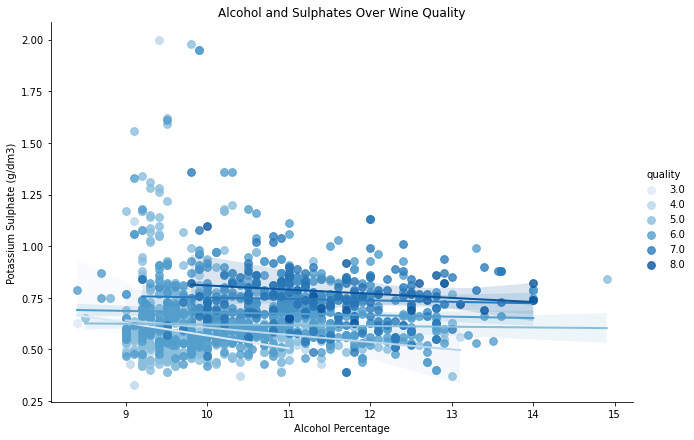

In [92]:
sns.lmplot(x='alcohol', y='sulphates', hue='quality', data=wine_df, palette="Blues", height=6, aspect=1.5, scatter_kws={'alpha':0.8, 's':60}, line_kws={'linewidth':2})
plt.title("Alcohol and Sulphates Over Wine Quality")
plt.ylabel("Potassium Sulphate (g/dm3)")
plt.xlabel("Alcohol Percentage")
plt.show()

This plot shows that the best quality wines have high values for both alcohol percentage and sulphate concentration, implying that high alcohol content and high sulphate concentrations together seem to produce better wines. There is a very slight downward slope, possibly because the best quality wines have slightly higher alcohol content than sulphate concentration.


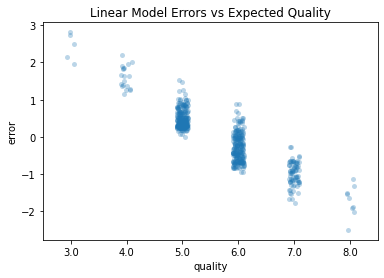

In [94]:


# Assuming wine_df is your DataFrame
# Splitting the data into training and test sets
train_data, test_data = train_test_split(wine_df, test_size=0.4, random_state=1221)

# Fit a linear model (example: using only 'alcohol' for simplicity)
model = LinearRegression()
model.fit(train_data[['alcohol']], train_data['quality'].astype(float))

# Predicting on test data
predictions = model.predict(test_data[['alcohol']])

# Creating a DataFrame for the plot
df = pd.DataFrame({
    'quality': test_data['quality'],
    'error': predictions - test_data['quality'].astype(float)
})

# Plotting
sns.stripplot(x='quality', y='error', data=df, alpha=0.3)
plt.title("Linear Model Errors vs Expected Quality")
plt.show()

This plot reveals that the error is much denser in the ‘Average’ quality section than in the ‘Good’ and ‘Bad’ quality wines. This is due to the fact that most of our dataset contains ‘Average’ quality wines, and there is not much data at the extreme ranges. The linear model with the R-squared value for m5 could only explain around 36% of the change in quality. The earlier models clearly show that due to the lack of information, this is not the best model to predict both ‘Good’ and ‘Bad’ quality wines.


In this analysis, I faced challenges in confidently predicting wine quality, particularly for 'Good' and 'Bad' wines, due to the dataset's concentration around 'Average' quality. A more comprehensive dataset would improve model accuracy. Initially, I suspected data issues when noticing some wines lacked citric acid, but further research clarified that citric acid is sometimes added to enhance acidity. I found that alcohol percentage, sulphate, and acid concentrations were key factors influencing wine quality. Notably, I encountered Simpson’s Paradox when volatile acids appeared to increase pH with acidity, revealing complex relationships between variables. For future studies, including wine rankings by multiple tasters could offer additional insights, considering human opinions in the analysis.

Comparision:

My analysis agrees with previuos analysis. Except for:

1. my citric acid distribution is a bit different which can happen due ti different bin length. 

2. My m5 model explains a slightly more variance which may be due to internal randomization of the algorithm.